**Intro**

In the following notebook, I will be creating a churn predictor for our bank 

**Read in libraries**

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Set Notebook Preferences**

In [54]:
#Set plot style
plt.style.use('Solarize_Light2')

#Set path to draw_data
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Bank Churn Analysis\Data\02_Cleaned_Data'

**Read in data**

In [55]:
df = pd.read_csv(path + '/2020_0720_Cleaned_Churn_Date.csv', index_col=0)

## Data Overview

**Preview data**

In [56]:
#Display data shape and head
print('Data shape:', df.shape)
display(df.head())


Data shape: (10000, 11)


,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,0,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1
3,699,France,0,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,0,43,2,125510.82,1,1,1,79084.10,0


**About the data - Info**

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      10000 non-null  int64  
 1   geography        10000 non-null  object 
 2   gender           10000 non-null  int64  
 3   age              10000 non-null  int64  
 4   tenure           10000 non-null  int64  
 5   balance          10000 non-null  float64
 6   numofproducts    10000 non-null  int64  
 7   hascrcard        10000 non-null  int64  
 8   isactivemember   10000 non-null  int64  
 9   estimatedsalary  10000 non-null  float64
 10  exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(1)
memory usage: 937.5+ KB


**About the data - Description Statistics**

In [58]:
df.describe()

,creditscore,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,0.545700,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,0.497932,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,0.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,1.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,1.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,1.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


# Machine Learning

## Prepare data

**Split data**

In [59]:
#Read in library
from sklearn.model_selection import train_test_split

#Seperate train/test data from target
X = df.drop('exited', axis = 1)
y = df.exited.values

#Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size =0.2, shuffle = False )

#Check
print('Training data shape:{} Label shape:{}'.format(X_train.shape, y_train.shape))
print('Test data shape:{} Label shape:{}'.format(X_test.shape, y_test.shape))

Training data shape:(8000, 10) Label shape:(8000,)
Test data shape:(2000, 10) Label shape:(2000,)


## Develop Preprocessing Pipeline

In [60]:
#Read in libraries
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_predict

#Get names of numeric/categorical features
num_features = X_train.select_dtypes(include = ['int64', 'float64']).columns
cat_features = X_train.select_dtypes(include = ['object']).columns

#Init steps for column transformera
num_transformer = Pipeline([('scaler', MinMaxScaler())])
cat_transformer = Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))])

#Build preprecessor
preprocessor = ColumnTransformer(transformers=[('numerics', num_transformer, num_features),
                                              ('categoricals', cat_transformer, cat_features)],
                                n_jobs=-1)

#Build initial pipeline
classifier = Pipeline([('Preprocessor', preprocessor)])

## Build Base Model - Naive Bayes Classifier

**Build base model and get predictions**

In [61]:
#Import naive bayes
from sklearn.naive_bayes import GaussianNB

#Append GaussianNB to pipeline
classifier.steps.append(['model', GaussianNB()])

#Get predictions on training data
predictions = cross_val_predict(classifier, X_train, y_train,  n_jobs=-1)

**Evaluate base model**

In [62]:
#Import classification report
from sklearn.metrics import classification_report, confusion_matrix

#Evaluate
print('Naive Bayes Classification Report: \n',classification_report(y_train, predictions))

Naive Bayes Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.94      0.89      6353
           1       0.60      0.37      0.46      1647

    accuracy                           0.82      8000
   macro avg       0.73      0.65      0.68      8000
weighted avg       0.80      0.82      0.80      8000



## Model Selection

Evaluate a series of additional models to later tune into final classifier.

Goal is to optimize recall, we do not want to mislabel people that will probably be leaving so we have a chance to intervene and keep them.

In [63]:
#Read in classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#Init classifiers
classifiers = [KNeighborsClassifier(n_jobs=-1),
LogisticRegression(n_jobs=-1,random_state = 24),
DecisionTreeClassifier(max_depth=10, random_state = 24),
RandomForestClassifier(max_depth=10, n_jobs=-1, random_state = 24)]

#Init model names
names= ['KNeighborsClassifier',
        'LogisticRegression',
'DecisionTreeClassifier',
'RandomForestClassifier'
    ]

In [64]:
#Write a for-loop that fits each model to the data and evaluated recall
for name, model in zip(names, classifiers):
    classifier.steps.pop(1) #Delete last step of pipe
    classifier.steps.append([name,model]) # append new step of pipe
    predictions = cross_val_predict(classifier, X_train, y_train, n_jobs=-1, cv = 5,)
    print('{} Classification Report:\n'.format(name), classification_report(y_train, predictions))
    print('===================================================')

KNeighborsClassifier Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.95      0.89      6353
           1       0.60      0.32      0.41      1647

    accuracy                           0.82      8000
   macro avg       0.72      0.63      0.65      8000
weighted avg       0.79      0.82      0.79      8000

LogisticRegression Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.96      0.89      6353
           1       0.61      0.22      0.32      1647

    accuracy                           0.81      8000
   macro avg       0.72      0.59      0.60      8000
weighted avg       0.78      0.81      0.77      8000

DecisionTreeClassifier Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.93      0.90      6353
           1       0.64      0.48      0.55      1647

    accuracy                           0.84    

## Tune RandomForest Classifier

**Tune with GridSearchCV**

In [70]:
#Import libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, make_scorer

#Get params from random forest
print('Params for RandomForestClassifier:\n',RandomForestClassifier().get_params())

#Set params to test over for gridsearchCV
params = {'model__random_state': [24],
          'model__n_jobs': [-1],
            'model__n_estimators': [100, 125, 150],
          'model__max_depth': [8,10,12],
           'model__min_samples_leaf': [1,2,3],
           'model__max_features':['auto', 'sqrt', 'log2']
          }

#Create scorer to optimize recall
scorer = {'precision_score': make_scorer(precision_score)}

#Update classifier
classifier.steps.pop(1) #Delete last step of pipe
classifier.steps.append(['model',RandomForestClassifier()]) #Append nRandomForestClassifier

Params for RandomForestClassifier:
 {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [71]:
#Init GridSearchCV to test params on training data
clf = GridSearchCV(classifier, param_grid=params, n_jobs=-1, cv=5, scoring=scorer, refit='precision_score')
clf.fit(X_train, y_train)

#Store cv_results_ and sort by mean_test_recall_score
grid_results = pd.DataFrame(clf.cv_results_)
grid_results.sort_values(by = 'mean_test_precision_score', inplace=True)
display(grid_results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__max_depth,param_model__max_features,param_model__min_samples_leaf,param_model__n_estimators,param_model__n_jobs,param_model__random_state,params,split0_test_precision_score,split1_test_precision_score,split2_test_precision_score,split3_test_precision_score,split4_test_precision_score,mean_test_precision_score,std_test_precision_score,rank_test_precision_score
67,0.923753,0.036109,0.395755,0.083483,12,sqrt,2,125,-1,24,"{'model__max_depth': 12, 'model__max_features'...",0.800000,0.794737,0.795699,0.744898,0.800000,0.787067,0.021195,79
76,0.938094,0.119803,0.365265,0.058088,12,log2,2,125,-1,24,"{'model__max_depth': 12, 'model__max_features'...",0.800000,0.794737,0.795699,0.744898,0.800000,0.787067,0.021195,79
58,0.929841,0.174482,0.469064,0.176148,12,auto,2,125,-1,24,"{'model__max_depth': 12, 'model__max_features'...",0.800000,0.794737,0.795699,0.744898,0.800000,0.787067,0.021195,79
77,1.242927,0.088864,0.473480,0.230752,12,log2,2,150,-1,24,"{'model__max_depth': 12, 'model__max_features'...",0.795455,0.803191,0.792553,0.750000,0.800995,0.788439,0.019591,76
68,1.304754,0.113089,0.375726,0.106649,12,sqrt,2,150,-1,24,"{'model__max_depth': 12, 'model__max_features'...",0.795455,0.803191,0.792553,0.750000,0.800995,0.788439,0.019591,76


In [72]:
#Store best estimator
tuned_forest = clf.best_estimator_

#View score and params of best estimator
print('Best Precision Score: {}\nBest params for RandomForestClassifier:\n{}'.format(round(clf.best_score_,3), clf.best_params_))

Best Precision Score: 0.818
Best params for RandomForestClassifier:
{'model__max_depth': 8, 'model__max_features': 'auto', 'model__min_samples_leaf': 1, 'model__n_estimators': 100, 'model__n_jobs': -1, 'model__random_state': 24}


**Plot precision recall curve**

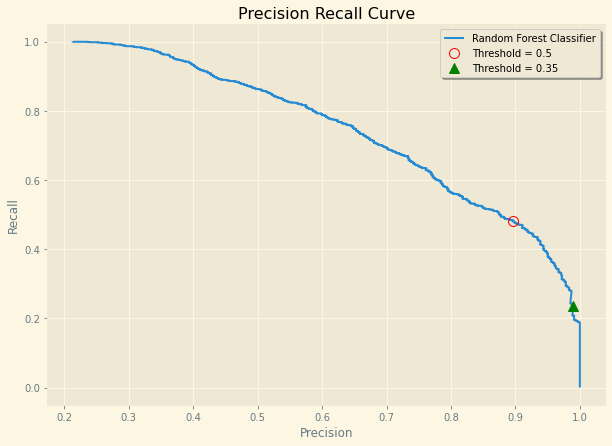

In [76]:
#Read in libraries
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, roc_auc_score, plot_roc_curve

#Create figure
f, ax = plt.subplots(figsize = (10,7))


#Get precision,recall, and threshold
precision, recall, thresholds = precision_recall_curve(y_train, tuned_forest.predict_proba(X_train)[:,1])

#Plot precision recall curve of tuned_forest
ax.plot(precision, recall, label = 'Tuned Random Forest', linewidth = 2)

#Plot threshold = .5
thresh_default = np.argmin(np.abs(thresholds - .5))
thresh_decreased = np.argmin(np.abs(thresholds - .75))
ax.plot(precision[thresh_default], recall[thresh_default], 'o', markersize = 10, markeredgecolor = 'red', color = 'none')
ax.plot(precision[thresh_decreased], recall[thresh_decreased], '^', markersize = 10,  color = 'green')

#Set plot aesthetics
ax.set_title('Precision Recall Curve')
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
ax.legend(['Random Forest Classifier', 'Threshold = 0.5', 'Threshold = 0.35'], frameon = True, shadow = True)

We'll want to decrease threshold to improve performance on recall for label 1

In [81]:
#Set Threshold
threshold = .75

#Fit model to training data 
predictions = tuned_forest.predict_proba(X_train)[:,1] >= threshold

print(confusion_matrix(y_train,predictions))
print(classification_report(y_train,predictions))

[[6349    4]
 [1261  386]]
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      6353
           1       0.99      0.23      0.38      1647

    accuracy                           0.84      8000
   macro avg       0.91      0.62      0.64      8000
weighted avg       0.87      0.84      0.80      8000



## Deploy on test data

In [82]:
#Fit model to test data 
predictions = tuned_forest.predict_proba(X_test)[:,1] >= threshold

#Print results
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

[[1605    5]
 [ 329   61]]
              precision    recall  f1-score   support

           0       0.83      1.00      0.91      1610
           1       0.92      0.16      0.27       390

    accuracy                           0.83      2000
   macro avg       0.88      0.58      0.59      2000
weighted avg       0.85      0.83      0.78      2000

